In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [ ]:
from totalface.model_zoo.model_common import load_onnx,load_tensorRT,load_tensorRT_multiple,load_openvino
from totalface.model_zoo.get_models import get_detection_model,get_landmark_model,get_recognition_model,get_ageGender_model,get_Race_model, \
    get_mask_model,get_liveness_model,get_expression_model
from totalface.face.get_result import get_detection, get_landmark, get_features,get_ageGender, \
    get_Race,get_mask,get_liveness,get_expression
from totalface.data import read_image,resize_image_multi

/usr/local/lib/python3.8/dist-packages/pycuda/compyte/dtypes.py:120: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  reg.get_or_register_dtype("bool", np.bool)


In [ ]:
from totalface.utils.util_common import draw_result,draw_result_land,draw_result_sim

In [ ]:
from totalface import print_info
print_info.info()

build 2022.06.30


# Detection Example

In [ ]:
# Load model

detection_name = "scrfd"
detection_path = "detection/scrfd_10g_bnkps.onnx"
#detection_path = "detection/scrfd_10g_bnkps_multiple.onnx"
#detection_path = "detection/scrfd_10g_bnkps.v7.trt"
#detection_path = "detection/scrfd_10g_bnkps_multiple.v7.trt"
#detection_path = ["detection/scrfd_10g_bnkps_multiple.xml",
#                 "detection/scrfd_10g_bnkps_multiple.bin"]


#detection_name = "retinaface_torch"

#detection_path = ["detection/retinaface_r50_final_multiple.xml",
#                 "detection/retinaface_r50_final_multiple.bin"]

In [ ]:
# Set parameters

detection_thresh = 0.5
detection_height_min=0 

In [ ]:
# Read image

input_path = "WiderFace/WIDER_val/images/10--People_Marching/10_People_Marching_People_Marching_2_433.jpg"

img = read_image(input_path)

dimg = img.copy() # for draw

In [ ]:
# if load multiple trt, load_multi=True, default False
#detection_model = get_detection_model(detection_name,detection_path,load_multi=True) #multiple
detection_model = get_detection_model(detection_name,detection_path)

providers: ['CUDAExecutionProvider']
scrfd onnx loaded


In [ ]:
# single scale
faces = get_detection(detection_name,detection_model,img,thresh=detection_thresh,height_min=detection_height_min,input_size=(640,640))

# multi scale
#faces,time_dict = get_detection(detection_name,detection_model,img,thresh=detection_thresh,height_min=detection_height_min,target_size=800,max_size=1200,time_return=True)
#faces = get_detection(detection_name,detection_model,img,thresh=detection_thresh,height_min=detection_height_min,target_size=800,max_size=1200)

# if time_return=True, return check time dictionary

In [ ]:
plt.figure(figsize=(10,10))
dimg2 = img.copy()
dimg2 = draw_result_land(dimg2,faces,point_size=10)
plt.imshow(dimg2)
plt.show()

# Landmark Example

In [98]:
#landmark_name='3ddfa'
#landmark_path = 'landmark/3ddfa_v2.onnx'

landmark_name = 'pipnet'
landmark_path = "landmark/pipnet/aflw/aflw_r18.onnx"

In [99]:
landmark_model = get_landmark_model(landmark_name,landmark_path)

providers: ['CUDAExecutionProvider']
pipnet onnx loaded


In [100]:
# faces result - (face.land = all points / face.land5 = 5 point (for align))

if landmark_name and landmark_path:
    #faces, param_lst, roi_box_lst = get_landmark(landmark_name,landmark_model,img,faces) # 3ddfa
    faces = get_landmark(landmark_name,landmark_model,img,faces) # pipnet 

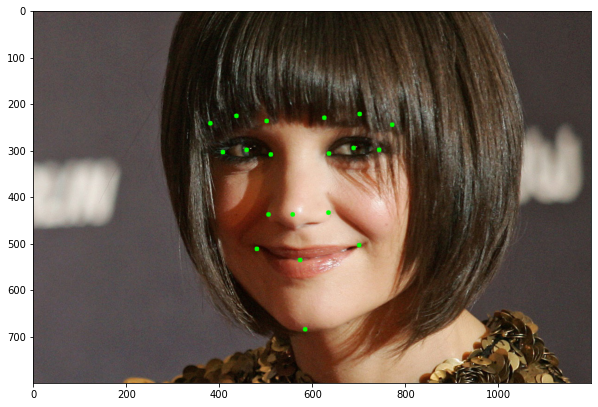

In [101]:
plt.figure(figsize=(10,10))
dimg = img.copy()
dimg = draw_result_land(dimg,faces,draw5=True,point_size=10) # if draw5 True (default False) , draw landmark 5 (face.land5)
plt.imshow(dimg)
plt.show()

# Recognition Example (Embedding)

In [17]:
recog_name = 'arcface'
recog_path = "recogniton.onnx"
recog_out_size=112
recog_num_features=512
recog_network='r50'
recog_fp16=True

sim_thresh = 0.4 

In [18]:
recog_model = get_recognition_model(recog_name,recog_path,out_size=recog_out_size,num_features=recog_num_features,network=recog_network,fp16=recog_fp16)

providers: ['CUDAExecutionProvider']
arcface onnx loaded


In [19]:
# reference image get feature, for similarity 
ref_path = "ref_imgs/ref_wider_F.jpg"
ref_feat = recog_model.get_ref(ref_path,to_bgr=True) # image size (112,112)
refs={'ref':ref_feat}

# if reference images..
'''
ref_dir = ""
refs={}

for img_name in os.listdir(ref_dir):
    pname = img_name.split(".")[0]
    img_format = img_name.split(".")[1]
    if not img_format in ['jpg','JPG','png']:
        continue
    img_path = os.path.join(ref_dirs,img_name)
    img_feat = recog_model.get_ref(img_path,to_bgr=True)
    refs[pname]=img_feat
'''

'\nref_dir = ""\nrefs={}\n\nfor img_name in os.listdir(ref_dir):\n    pname = img_name.split(".")[0]\n    img_format = img_name.split(".")[1]\n    if not img_format in [\'jpg\',\'JPG\',\'png\']:\n        continue\n    img_path = os.path.join(ref_dirs,img_name)\n    img_feat = recog_model.get_ref(img_path,to_bgr=True)\n    refs[pname]=img_feat\n'

In [20]:
faces = get_features(recog_name,recog_model,img,faces,to_bgr=True)

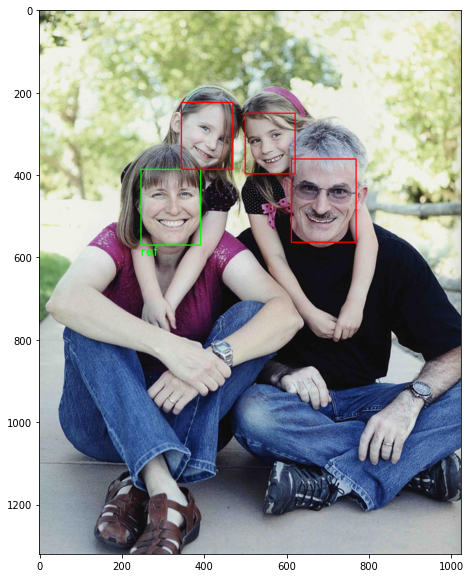

In [21]:
plt.figure(figsize=(10,10))
dimg = img.copy()

# if all_draw=True, not sim face red box, sim face green box
# if all_draw=False, sim face green box
dimg = draw_result_sim(dimg,faces,refs,sim_thresh=sim_thresh,ga=False,to_bgr=False,all_draw=True,max_sim=False)
plt.imshow(dimg)
plt.show()

# Agender Example

In [22]:
ag_name='arcface_cmt'
ag_path = "agender.onnx"
ag_out_size=112
ag_num_features=512
ag_network='r50'

In [23]:
ag_model = get_ageGender_model(ag_name, ag_path,ag_out_size,num_features=ag_num_features,network=ag_network)

providers: ['CUDAExecutionProvider']
arcface_cmt onnx loaded


In [25]:
faces = get_ageGender(ag_name,ag_model,img,faces,to_bgr=False)

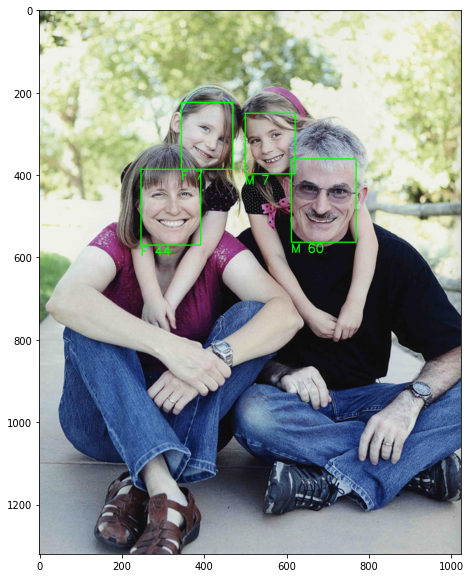

In [26]:
plt.figure(figsize=(10,10))
dimg = draw_result(img,faces,ga=True,to_bgr=False)
plt.imshow(dimg)
plt.show()

In [ ]:
# Race 

In [ ]:
race_name = 'arcface_race'
race_path = "race_model.onnx"
race_out_size = 112

race_model = get_Race_model(race_name, race_path,race_out_size)


In [ ]:
faces = get_Race(race_name,race_model,img,faces,to_bgr=False)

In [ ]:
# Spoofing (liveness)

In [ ]:
spoof_path = "spoof_model.onnx"

spoof_model = get_liveness_model(spoof_path)

In [ ]:
faces = get_liveness(spoof_model)

In [ ]:
# Mask Detection

In [ ]:
maskD_path = "maskD_model.onnx"

maskD_model = get_mask_model(maskD_path)

In [ ]:
faces = get_mask(maskD_model,faces) # all faces mask detection

In [ ]:
# Expression

In [ ]:
exp_path = "exp_model.onnx"

exp_model = get_expression(exp_path)

In [ ]:
faces = get_expression(exp_model,faces) # all faces expression recognition

In [ ]:
# Blur ( Blurring faces determined to be similar to the ref image )
# use tddfa for get landmarks

In [ ]:
from totalface.face.blur import face_blur_image,load_tddfa

In [ ]:
frame_path = "test.jpg"
img = read_image(frame_path)
ref_path = "ref.jpg"
ref_img = read_image(ref_path)

In [ ]:
tddfa_path = "tddfa/3ddfa_v2"
tddfa_format='vino'

tddfa_model = load_tddfa(tddfa_path,tddfa_format)

In [ ]:
# Put ref_img, recog_model and detect anything less than score_th=1.3 (default) and process it as blur
blur_image = face_blur_image(img,detection_name,detection_model,tddfa_model,recog_model,ref_img) 

# If ref_img and recog_model are not included, all detects are blurred.
blur_image2 = face_blur_image(img,detection_name,detection_model,tddfa_model)